In [1]:
import os
import pandas as pd
import numpy as np
import time
import random as rd
import csv
import ta
import random
from pathlib import Path
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import statsmodels.api as sma
import statsmodels.stats.outliers_influence  as smo
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import joblib

import sqlite_io as sio
import add_indicators as indic
import split_merge as sm
import balance
import model_mngr as modmgr

In [15]:
PATH_DATA = "C:\\Projets\\Data"
PATH_DB_FWK="C:\\Projets\\Data\\sqlite\\dataset_market.db"
PATH_DB_STOCK="C:\\Projets\\Data\\sqlite\\dataset_paris_stock_adjusted.db"
PATH_DATA_DTS=PATH_DATA+"\\DTS_FULL\\"


CONNECTION TO SQLITE

In [3]:
if "con_stock" in locals():
        sio.close_connection(con_stock)
con_stock = sio.get_connection(str_db_path=PATH_DB_STOCK)

if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

my_session_maker = sessionmaker(bind=con_fwk)
session=my_session_maker()

table_stock="DS_PARIS_1D_ADJ_CLEAN"

GET DATA

In [ ]:
dts_name="PARIS_TREND_1D_20D_V1"
multi_symbol="PARIS_STOCK"

df_base=sio.get_candles_to_df(session=session,con=con_stock, target_table=table_stock)
df_work=pd.DataFrame()
for code_value in df_base.index.get_level_values('CODE').unique():
    sub_df=df_base[df_base.index.get_level_values('CODE') == code_value]
    df_work_tmp = indic.add_indicators_to_df(con=con_fwk, df_in=sub_df, dts_name=dts_name,symbol=multi_symbol)
    df_work = pd.concat([df_work, df_work_tmp])
    
df_work.sort_index(inplace=True)
df_work.info() 

In [5]:
# df_work[10000:10010]
# pd.set_option('display.max_columns', None)
# print(df_work.describe())

# df_work.round(5).to_csv(
    PATH_DATA_DTS+"PARIS_TREND_1D_20D_V1_BASE.zip", sep=",")

In [18]:
dts_name="PARIS_TREND_1D_20D_V1"
# dts_name="PARIS_TREND_1D_50D_V1"
multi_symbol="PARIS_STOCK"

df_work=pd.read_csv(PATH_DATA_DTS+dts_name+"_BASE.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
df_work.head(5)

,,OPEN,HIGH,LOW,CLOSE,VOLUME,sma20,pos_sma20,sma50,sma200,pos_sma50,...,donchian20_lo,pos_donchian20_hi,pos_donchian20_lo,adx14,adx14_neg,adx14_pos,adx14_dif,avg_vol14,pos_avg_vol14,pos_sma20_200
OPEN_DATETIME,CODE,,,,,,,,,,,,,,,,,,,,,
2000-01-03,AAA.PA,20.3331,20.8291,20.3331,20.8291,45.0,NaN,NaN,20.82910,NaN,0.00000,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2000-01-04,AAA.PA,20.8291,20.8291,20.8291,20.8291,10.0,NaN,NaN,20.82910,NaN,0.00000,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2000-01-05,AAA.PA,20.8291,21.8209,20.8291,21.8209,20.0,NaN,NaN,21.15970,NaN,0.03125,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2000-01-06,AAA.PA,22.8128,22.8128,22.8128,22.8128,30.0,NaN,NaN,21.57298,NaN,0.05747,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2000-01-07,AAA.PA,23.8046,23.8046,23.8046,23.8046,25.0,NaN,NaN,22.01930,NaN,0.08108,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN


Check Dataframe

In [19]:
df_check=df_work[df_work['stdev20_1d'] > 1000]
# df_check=df_check[df_check['ret_1d'] <= 2]
df_check.index.get_level_values('CODE').unique()
# df_check[df_check.index.get_level_values('CODE')=='AKW.PA']
# df_check=df_work[df_work.index.get_level_values('CODE')=='AI.PA']
# CATG
mask = df_work['stdev20_1d'] > 1000
df_work.drop(df_work[mask].index, inplace=True)
# df_check[6000:6010]


In [20]:
df_work = indic.drop_indicators_by_type(
    con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol, ind_type=0)
list_label = indic.get_ind_list_by_type_for_dts(
    con=con_fwk, dts_name=dts_name, symbol_code=multi_symbol, ind_type=2)
print(list_label)

           LABEL
0   lab_perf_20d
1   lab_perf_50d
2  lab_perf_125d


In [21]:
df_work=df_work.droplevel('CODE')
df_work.sort_index(inplace=True)
df_work.head(5)

,OPEN,HIGH,LOW,CLOSE,VOLUME,pos_sma20,pos_sma50,pos_sma200,pos_sma50_200,pos_sma20_50,...,stoch14_dif,cmf_20,pos_donchian20_hi,pos_donchian20_lo,adx14,adx14_neg,adx14_pos,adx14_dif,pos_avg_vol14,pos_sma20_200
OPEN_DATETIME,,,,,,,,,,,,,,,,,,,,,
1989-01-16,1.9958,2.0179,1.9847,1.9958,663163.0,NaN,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1989-01-17,1.9958,1.9958,1.9958,1.9958,0.0,NaN,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1989-01-18,1.9958,1.9958,1.9958,1.9958,0.0,NaN,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1989-01-19,1.9442,1.9682,1.9368,1.9442,1641505.0,NaN,-0.01952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1989-01-20,1.9350,1.9663,1.9350,1.9350,1129887.0,NaN,-0.01942,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


In [26]:
lab_studied = "lab_perf_50d"
algo_studied = "XG_BOOST_CLASS"
dts_name="PARIS_TREND_1D_50D_V1"

df_work_lab = indic.drop_indicators_not_selected(con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol,label=lab_studied,algo=algo_studied)

df_split=sm.split_df_by_label_strat(
    df_in=df_work_lab, list_label=[lab_studied], split_timeframe="M",random_split=False,split_strat=(80,10,10))
df_selected = df_split['df_'+lab_studied+'_train']
df_valid = df_split['df_'+lab_studied+'_valid']
df_confirm = df_split['df_'+lab_studied+'_confirm']
df_selected.sort_index(inplace=True)
df_valid.sort_index(inplace=True)
df_confirm.sort_index(inplace=True)

print(f"selected: {df_selected.shape=} valid: {df_valid.shape=} confirm: {df_confirm.shape=}")


selected: df_selected.shape=(941742, 19) valid: df_valid.shape=(264951, 19) confirm: df_confirm.shape=(280061, 19)


In [24]:
label=lab_studied
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=lab_studied,nb_class=5,bool_replace_label=False)
min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
print(min_max_lab_by_class)

                        min      max
lab_perf_50d_class                  
0                  -0.87651 -0.07873
1                  -0.07872 -0.00781
2                  -0.00780  0.04764
3                   0.04765  0.12387
4                   0.12388  5.59504


In [27]:
label=lab_studied
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=lab_studied,nb_class=5,bool_replace_label=True)
df_class.sort_index(inplace=True)
categ_50={0:[-1,-0.07876],1:[-0.07876,-0.00783],2:[-0.00783,0.04790],3:[0.04790,0.12406],4:[0.12406,6]}
categ_20={0:[-1,-0.05172],1:[-0.05172,-0.00868],2:[-0.00868,0.02272],3:[0.02272,0.07058],4:[0.07059,5]}
df_class_val=balance.add_lab_by_class(df_in=df_valid,str_label=lab_studied, categ=categ_50,bool_replace_label=True) # categ
df_class_val.sort_index(inplace=True)
df_class_conf=balance.add_lab_by_class(df_in=df_confirm,str_label=lab_studied, categ=categ_50,bool_replace_label=True) # categ
df_class_conf.sort_index(inplace=True)
print(df_class.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_val.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_conf.loc[:, label].dropna().iloc[[0, -1]])
# df_class_clean=df_class.drop(['OPEN','HIGH','LOW','CLOSE','VOLUME','lab_perf_125d','lab_perf_20d','lab_perf_50d'],axis=1)
data = df_class[label]
print(data.value_counts().sort_index())
data_val = df_class_val[label]
print(data_val.value_counts().sort_index())
data_conf = df_class_conf[label]
print(data_conf.value_counts().sort_index())
# min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
# print(min_max_lab_by_class)

#                         min      max
# lab_perf_20d_class                  
# 0                  -0.87743 -0.05172
# 1                  -0.05171 -0.00868
# 2                  -0.00867  0.02272
# 3                   0.02273  0.07058
# 4                   0.07059  3.82176

OPEN_DATETIME
1989-10-20    3
2017-01-31    4
Name: lab_perf_50d, dtype: int64
OPEN_DATETIME
2017-02-01    3.0
2020-06-30    3.0
Name: lab_perf_50d, dtype: float64
OPEN_DATETIME
2020-07-01    2.0
2023-11-01    2.0
Name: lab_perf_50d, dtype: float64
lab_perf_50d
0    188357
1    188352
2    188359
3    188332
4    188342
Name: count, dtype: int64
lab_perf_50d
0.0    63755
1.0    55771
2.0    53282
3.0    46450
4.0    45647
Name: count, dtype: int64
lab_perf_50d
0.0    67867
1.0    59886
2.0    51878
3.0    47121
4.0    53306
Name: count, dtype: int64


In [28]:
list_feat = df_class.columns.values.tolist()
list_feat.remove(label)
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)
df_x_val, col_y_val = sm.split_df_x_y(
    df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)
df_x_conf, col_y_conf = sm.split_df_x_y(
    df_in=df_class_conf, list_features=list_feat, str_label=label, drop_na=True)

df_class.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_TRAIN.zip", sep=",")
df_class_val.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_VAL.zip", sep=",")
df_class_conf.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_CONF.zip", sep=",")

In [29]:
dts_name="PARIS_TREND_1D_50D_V1"
multi_symbol="PARIS_STOCK"
label = "lab_perf_50d"

df_class=pd.read_csv(PATH_DATA_DTS+dts_name+"_TRAIN.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class.dropna(subset=[label], inplace=True)
df_class.sort_index(inplace=True)
df_class_val=pd.read_csv(PATH_DATA_DTS+dts_name+"_VAL.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_val.dropna(subset=[label], inplace=True)
df_class_val.sort_index(inplace=True)

list_feat = df_class.columns.values.tolist()
list_feat.remove(label)
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)

X = df_class_val.drop(label, axis=1, inplace=False)
y = df_class_val[label]
method = RandomUnderSampler(sampling_strategy={0:45000,1:45000,2:45000,3:45000,4:45000}) # 47000 pour lab 20 et 45000 pour lab 50
df_x_val, col_y_val=  method.fit_resample(X, y)
print(col_y_val.value_counts().sort_index())
# df_x_val, col_y_val = sm.split_df_x_y(
    # df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)

lab_perf_50d
0.0    45000
1.0    45000
2.0    45000
3.0    45000
4.0    45000
Name: count, dtype: int64


Correlation

In [ ]:
corr_train = df_x_train.corr()
fig, ax = plt.subplots(figsize=(6, 6))
corr_train.replace(1,0,inplace=True)
corr_train=corr_train.applymap(lambda x : None if x< 0.8 and x>-0.8 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)

corr_train_check=corr_train[corr_train >0.8]
corr_train_check.head()
sns.heatmap(corr_train_check, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)


In [ ]:
df_x_train_VIF = sma.add_constant(df_x_train)
vif = pd.DataFrame()
vif["feature"]=df_x_train_VIF.columns
vif["VIF"]= [smo.variance_inflation_factor(df_x_train_VIF.values, i) for i in range(df_x_train_VIF.shape[1])]
print(vif)

In [ ]:
rnd_key=28
n_jobs=3

df_usamp=df_x_train[:300000]
print(f"{df_usamp.shape=}")
df_x_boruta, col_y_boruta = sm.split_df_x_y(
    df_in=df_usamp, list_features=list_feat, str_label=label, drop_na=True)

rf_bo = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key))
boruta_selector.fit(df_x_boruta.values, col_y_boruta.values)
selected_features = df_x_boruta.columns[boruta_selector.support_]
print(selected_features)

not_selected_features = set(df_x_boruta.columns) - set(selected_features)
print(not_selected_features)

XGBoost

In [19]:
pd.set_option('display.max_columns', None)
# print(df_x_train.describe())

print(f"{df_x_train.shape=} {df_x_val.shape=} {col_y_train.size=} {col_y_val.size=}")



df_x_train.shape=(940314, 28) df_x_val.shape=(263759, 28) col_y_train.size=940314 col_y_val.size=263759


In [ ]:

rnd_key=28
n_jobs=2

col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)

time_split = TimeSeriesSplit(n_splits=5)

eval_set=[(df_x_val, col_y_val_int)]

print(f"{df_x_train.shape=} {df_x_val.shape=} {col_y_train_int.size=} {col_y_val_int.size=}")

scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision_weighted': metrics.make_scorer(metrics.precision_score, average='weighted'),
    'recall_weighted': metrics.make_scorer(metrics.recall_score, average='weighted'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average='weighted')
}


grid = {
    # default 1 subsample ratio of columns when constructing each tree
    # "colsample_bytree": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # "colsample_bylevel": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # "colsample_bynode": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # default 0 minimum loss reduction to make a further patition on a leaf [x for x in np.linspace(0, 0.1, num=2, endpoint=True)]
    "gamma": [0],
    # [x for x in np.linspace(0.01, 0.3, num=8, endpoint=True)],  # default 0.1 [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "learning_rate": [0.1],
    # default 6 max depth of the tree 
    "max_depth": [int(x) for x in np.linspace(5, 7, num=3, endpoint=True, dtype=int)],
    # default 100
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=150, num=3, endpoint=True, dtype=int)],
    # default 1 subsample ratio of the training instances
    # [x for x in np.linspace(0.6, 1.0, num=3, endpoint=True)],[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    "subsample": [1.0],
    # default 1 minimum sum of instance weight needed in a child
    # "min_child_weight": [x for x in np.linspace(0.5, 3, num=6, endpoint=True)],
    # default 0 Maximum delta step we allow each leaf output to be.
    "max_delta_step": [0]
    # default 1 L2 regularization term on weights. Increasing this value will make model more conservative.
    #"lambda": [0.5, 1, 1.5, 2],
    # default 0 L1 regularization term on weights. Increasing this value will make model more conservative.
    #"alpha": [0, 0.25, 0.5, 0.75, 1, 1.5, 2]

}

xgb_class = xgb.XGBClassifier(objective='multi:softmax', num_class=5,early_stopping_rounds=5,eval_metric='merror')
#18min pour 1 cas
xgb_fitted = modmgr.search_cv_fit_report(estimator=xgb_class, params=grid,
                                         x_train=df_x_train, y_train=col_y_train_int,cv=time_split,eval_set=eval_set,
                                           n_iter=20, n_top=10, method='grid', scoring=scoring, refit='precision_weighted',n_jobs=n_jobs)

mean_test_precision_weighted = xgb_fitted.cv_results_['mean_test_precision_weighted']
params=xgb_fitted.cv_results_['params']

ranked=np.argsort(-mean_test_precision_weighted)

for rank,score_idx in enumerate(ranked):
    if rank<20:
        params_str = ', '.join(f"{param}: {value}" for param, value in params[score_idx].items())
        print(f"Rank {rank+1}: mean_test_precision_weighted {mean_test_precision_weighted[score_idx]:.4f}, Parameters: {params_str}")


[0]	validation_0-merror:0.74860
[1]	validation_0-merror:0.74794
[2]	validation_0-merror:0.74708
[3]	validation_0-merror:0.74692
[4]	validation_0-merror:0.74702
[5]	validation_0-merror:0.74654
[6]	validation_0-merror:0.74600
[7]	validation_0-merror:0.74627
[8]	validation_0-merror:0.74656
[9]	validation_0-merror:0.74644
[10]	validation_0-merror:0.74643
[11]	validation_0-merror:0.74593
[12]	validation_0-merror:0.74560
[13]	validation_0-merror:0.74552
[14]	validation_0-merror:0.74552
[15]	validation_0-merror:0.74561
[16]	validation_0-merror:0.74536
[17]	validation_0-merror:0.74548
[18]	validation_0-merror:0.74559
[19]	validation_0-merror:0.74594
[20]	validation_0-merror:0.74598
Accuracy XGBoost classifier Training score : 0.3294777125794538
Accuracy XGBoost classifier Validation score :0.25463555555555556


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

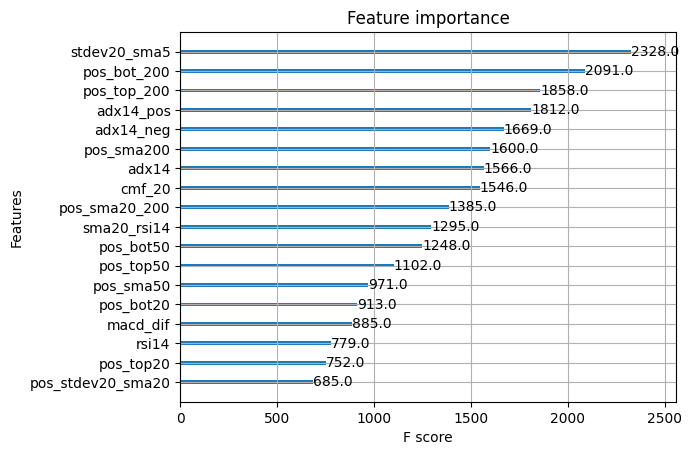

In [30]:
rnd_key=28
params={'gamma':0,'subsample': 1.0, 'n_estimators': 40, 'max_depth': 8, 'learning_rate': 0.1, 'max_delta_step':0, 'min_child_weight':3.0}

col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)

eval_set=[(df_x_val, col_y_val_int)]

objective='multi:softproba' # multi:softmax multi:softproba

xgb_class = xgb.XGBClassifier(objective=objective, num_class=5,early_stopping_rounds=5,eval_metric='merror', random_state=int(rnd_key),
                           learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],max_delta_step=params['max_delta_step'],
                        #    colsample_bytree=params['colsample_bytree'],#colsample_bynode= 0.5, colsample_bylevel= 0.5, min_child_weight=params['min_child_weight'],
                            max_depth=params['max_depth'], n_estimators=params['n_estimators'], verbosity=1)

xgb_class.fit(df_x_train, col_y_train_int,eval_set=eval_set)

print(f"Accuracy XGBoost classifier Training score : {xgb_class.score(df_x_train, col_y_train_int)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(
    f"Accuracy XGBoost classifier Validation score :{xgb_class.score(df_x_val, col_y_val_int)}")

# print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_class)


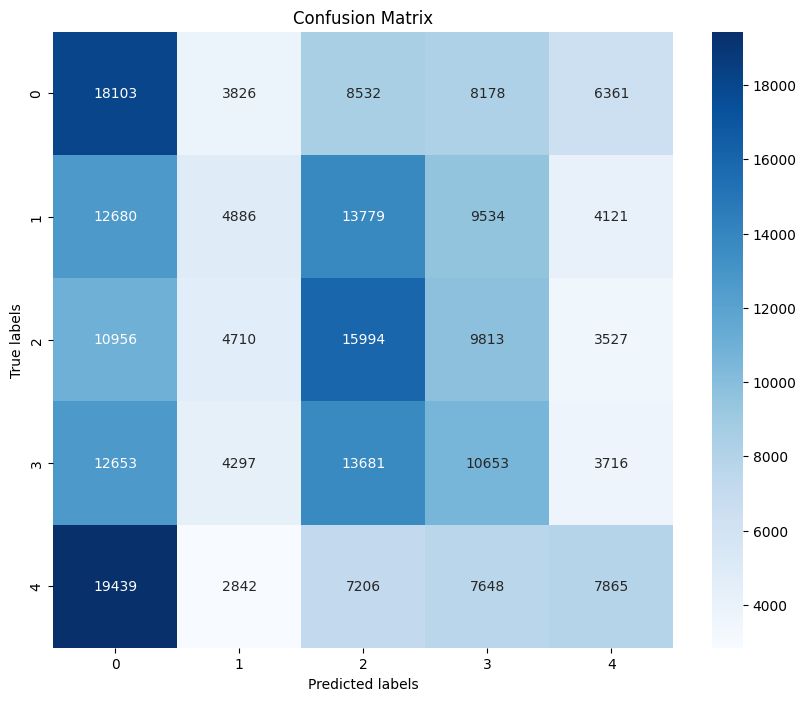

In [21]:
y_pred = xgb_class.predict(df_x_val)

conf_matrix = metrics.confusion_matrix(col_y_val_int, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
y_pred_proba = xgb_class.predict_proba(df_x_val)
print(y_pred_proba)

PATH_MODEL = "../../../Data/Models/"
ext_pkl = ".pkl"
xgb_suffix = "_xgb_class"
joblib.dump(xgb_class, PATH_MODEL+"PARIS_TREND_1D_20D_V1_"+lab_studied+xgb_suffix+ext_pkl)

[[0.16517605 0.2282017  0.20977029 0.23220775 0.16464421]
 [0.16905953 0.22478357 0.19554472 0.2203653  0.19024687]
 [0.15897289 0.22017834 0.19852538 0.21876304 0.20356041]
 ...
 [0.28013682 0.16626091 0.13296892 0.17726468 0.24336869]
 [0.21418212 0.18473119 0.16306874 0.18441728 0.2536007 ]
 [0.28274298 0.1578403  0.12017644 0.14287868 0.29636157]]


['../../../Data/Models/PARIS_TREND_1D_20D_V1_lab_perf_20d_xgb_class.pkl']

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

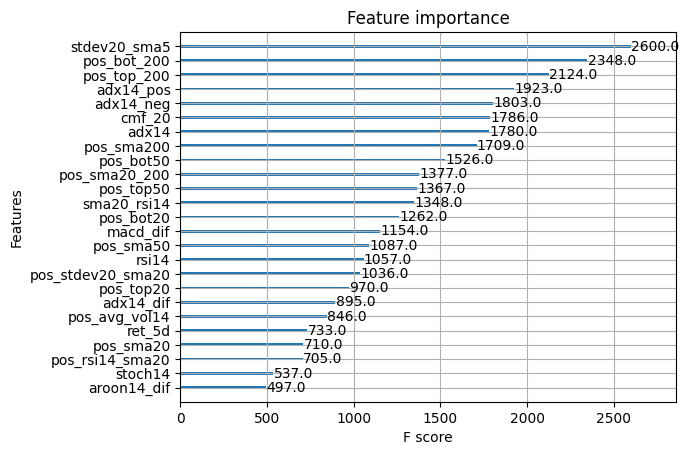

In [23]:
dts_name="PARIS_TREND_1D_20D_V1"
multi_symbol="PARIS_STOCK"
lab_studied = "lab_perf_20d"
xgb_class = joblib.load(PATH_MODEL+"PARIS_TREND_1D_20D_V1_"+lab_studied+xgb_suffix+ext_pkl)
xgb.plot_importance(xgb_class)
